In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import itertools
import os

import torchvision.models as models
import torchvision.transforms as transforms

c:\Users\fergu\Documents\PersonalProjects\Logo_Detection\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class Img2Vec():

    def __init__(self, model_name):
        self.device = self.set_device()
        self.architecture = model_name
        self.model = self.initiate_model()
        self.embed = self.assign_layer()
        self.dataset = {}

    
    def set_device(self):
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
        
        return device
    
    
    def initiate_model(self):
        
        m = getattr(models, self.architecture) # equ to models.resnet50() 
        model = m(weights='DEFAULT')
        
        return model.to(self.device)
    

    def assign_layer(self):
        embed_dict = {
            "resnet50": self.obtain_children,
            "vgg19":  self.obtain_classifier,
            "efficientnet_b0": self.obtain_classifier
        }

        model_embed = embed_dict[self.architecture]()

        return model_embed
    

    def obtain_children(self):
        model_embed = nn.Sequential(*list(self.model.children())[:-1])
        
        return model_embed


    def obtain_classifier(self):
        self.model.classifier = self.model.classifier[:-1]
        
        return self.model
    

    def transform_img(self, img):

        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
            ])
        
        return transform(img)
    

    def directory_to_list(self, source):

        types = (
            '.png',
            '.jpg',
            '.jpeg'
        )
        
        dir_list = os.listdir(source)
        source_list = [
            os.path.join(source, f) for f in dir_list 
            if os.path.splitext(f)[1] in types
            ]

        return source_list
        
    
    def validate_source(self, source):

        if isinstance(source, list):
            source_list = [f for f in source if os.path.isfile(f)]
        elif os.path.isdir(source):
            source_list = self.directory_to_list(source)
        elif os.path.isfile(source):
            source_list = [source]
        else:
            raise ValueError('"source" expected as file, list or directory.')
        
        return source_list

    
    def embed_image(self, img):
        
        img = Image.open(img)
        img_trans = self.transform_img(img)

        if self.device == "cuda:0":
            img_trans = img_trans.cuda()
        
        img_trans = img_trans.unsqueeze(0)

        return self.embed(img_trans)

    
    def embed_dataset(self, source):
        
        self.files = self.validate_source(source)    

        for file in self.files:
            vector = self.embed_image(file)
            self.dataset[str(file)] = vector
            
    
    def similar_images(self, target_file, n=None):

        target_vector = self.embed_image(target_file)
        cosine = nn.CosineSimilarity(dim=1)

        sim_dict = {}
        for k, v in self.dataset.items():
            sim = cosine(v, target_vector)[0].item()
            sim_dict[k] = sim
        
        sim_dict = {k: v for k, v in sorted(sim_dict.items(), 
                                            key=lambda item: item[1], 
                                            reverse=True)}

        if n is not None:
            sim_dict = dict(list(sim_dict.items())[:n])

        self.output_images(sim_dict, target_file)

        return sim_dict
    

    def output_images(self, similar, target):

        self.display_img(target, 'original')

        for k, v in similar.items():
            self.display_img(k, 'similarity:' + str(v))

        return
    

    def display_img(self, path, title):

        plt.imshow(Image.open(path))
        plt.axis('off')
        plt.title(title)
        plt.show()

        return


    def save_dataset(self, path):
        
        data = {
            "model": self.architecture,
            "embeddings": self.dataset
            }
        
        torch.save(data, os.path.join(path,'tensors.pt')) #need to update functionality for naming convention

        return
    

    def load_dataset(self, source):

        data = torch.load(source)

        if data["model"] == self.architecture:
            self.dataset = data["embeddings"]
        else:
            raise AttributeError(
                f'NN architecture "{self.architecture}" does not match the '
                +f'"{data["model"]}" model used to generate saved embeddings. '
                +'Re-initiate Img2Vec with correct architecture and reload.'
                )
        
        return
        



In [12]:
test = Img2Vec('resnet50')
# print(test.device)
# print(test.architecture)
# print(test.model)
# print(test.embed)

In [13]:
test.embed_dataset("C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/")
test.files

['C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table2.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table3.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table4.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table5.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table6.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table7.jpg',
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table8.jpg']

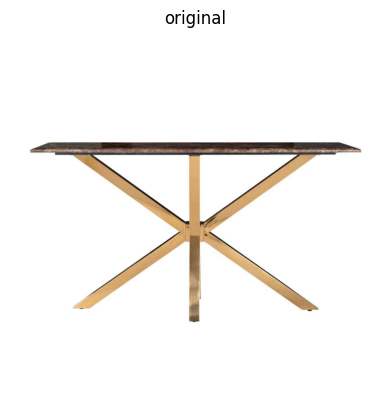

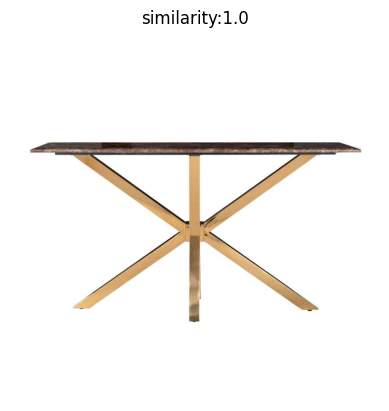

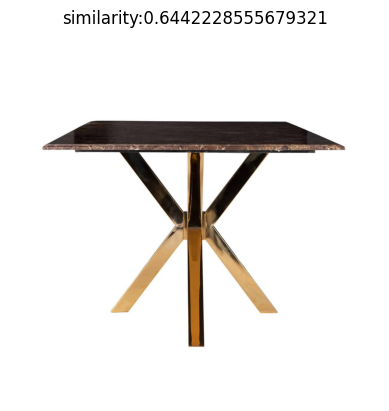

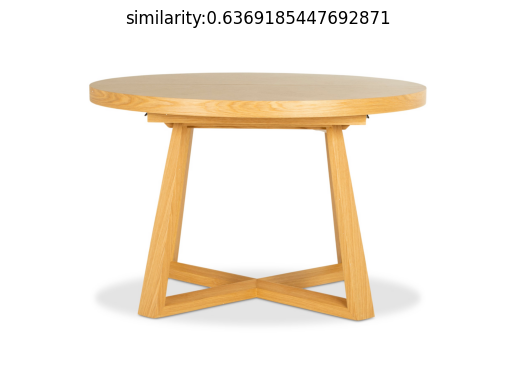

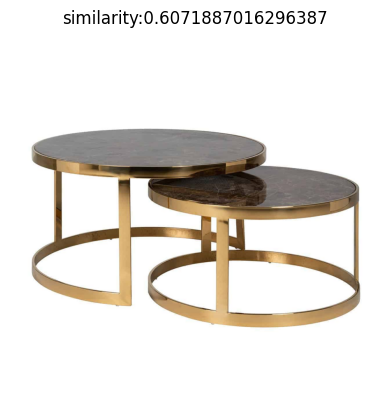

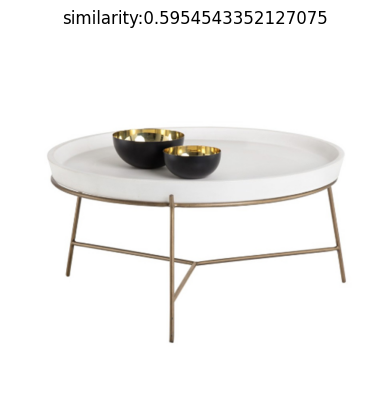

{'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg': 1.0,
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table2.jpg': 0.6442228555679321,
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table4.jpg': 0.6369185447692871,
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table3.jpg': 0.6071887016296387,
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table6.jpg': 0.5954543352127075}

In [16]:
test.similar_images("C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg", n=5)

In [6]:
test.save_dataset("C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data")

In [4]:
test.load_dataset("C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/tensors.pt")

AttributeError: NN architecture "vgg19" does not match the "resnet50" model used to generate saved embeddings. Re-initiate Img2Vec with correct architecture and reload.

In [32]:
test.dataset

{'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg': tensor([[[[0.2717]],
 
          [[0.0309]],
 
          [[0.0592]],
 
          ...,
 
          [[0.0275]],
 
          [[0.0466]],
 
          [[0.0000]]]], device='cuda:0', requires_grad=True),
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table2.jpg': tensor([[[[0.0334]],
 
          [[0.0041]],
 
          [[0.4830]],
 
          ...,
 
          [[0.4878]],
 
          [[0.1754]],
 
          [[0.1095]]]], device='cuda:0', requires_grad=True),
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table3.jpg': tensor([[[[0.2033]],
 
          [[0.0966]],
 
          [[0.2993]],
 
          ...,
 
          [[0.2001]],
 
          [[0.0000]],
 
          [[0.1124]]]], device='cuda:0', requires_grad=True),
 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table4.jpg': tensor([[[[0.2599]],
 
       

In [29]:
print(test.dataset)

{'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg': tensor([[[[0.2717]],

         [[0.0309]],

         [[0.0592]],

         ...,

         [[0.0275]],

         [[0.0466]],

         [[0.0000]]]], device='cuda:0', grad_fn=<MeanBackward1>), 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table2.jpg': tensor([[[[0.0334]],

         [[0.0041]],

         [[0.4830]],

         ...,

         [[0.4878]],

         [[0.1754]],

         [[0.1095]]]], device='cuda:0', grad_fn=<MeanBackward1>), 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table3.jpg': tensor([[[[0.2033]],

         [[0.0966]],

         [[0.2993]],

         ...,

         [[0.2001]],

         [[0.0000]],

         [[0.1124]]]], device='cuda:0', grad_fn=<MeanBackward1>), 'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table4.jpg': tensor([[[[0.2599]],

         [[0.1492]],

         [

{'arch': 'resnet',
 'data': {'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table1.jpg': tensor([[[[0.2717]],
  
           [[0.0309]],
  
           [[0.0592]],
  
           ...,
  
           [[0.0275]],
  
           [[0.0466]],
  
           [[0.0000]]]], device='cuda:0', grad_fn=<MeanBackward1>),
  'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table2.jpg': tensor([[[[0.0334]],
  
           [[0.0041]],
  
           [[0.4830]],
  
           ...,
  
           [[0.4878]],
  
           [[0.1754]],
  
           [[0.1095]]]], device='cuda:0', grad_fn=<MeanBackward1>),
  'C:/Users/fergu/Documents/PersonalProjects/Image_Clustering/data/furniture_imgs/table3.jpg': tensor([[[[0.2033]],
  
           [[0.0966]],
  
           [[0.2993]],
  
           ...,
  
           [[0.2001]],
  
           [[0.0000]],
  
           [[0.1124]]]], device='cuda:0', grad_fn=<MeanBackward1>),
  'C:/Users/fergu/Documents/PersonalProject

In [101]:
cosine = nn.CosineSimilarity(dim=1)

In [102]:
cosine(embedding, embedding2)[0]

tensor([[1.]], device='cuda:0', grad_fn=<SelectBackward0>)

In [6]:
def set_device():
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
    
    return device


def initiate_model(model_name: str):

    m = getattr(models, model_name)
    model = m(weights='DEFAULT')
    device = set_device()

    return model.to(device)


def obtain_children(model):
     
     model_embed = nn.Sequential(*list(model.children())[:-1])

     return model_embed


def obtain_classifier(model):

    model.classifier = model.classifier[:-1]
    
    return model


def assign_layer(model, model_name):

    embed_dict = {
        "resnet50": obtain_children,
        "vgg19":  obtain_classifier,
        "efficientnet_b0": obtain_classifier
    }

    model_embed = embed_dict[model_name](model)

    return model_embed